In [35]:
%pip install google-genai


In [36]:
import google.generativeai as genai

In [37]:
from google.colab import userdata
import os

# This line will fail if the secret 'secretName' is not configured
# in the Colab notebook's secrets panel, or if notebook access is not enabled.
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [38]:
!apt-get update -qq && apt-get install -qq locales
!locale-gen en_US.UTF-8
!update-locale LANG=en US.UTF-8 LC_ALL=en_US.UTF-8

!apt-get -qq -y install espeak-ng > /dev/null 2>&1
%pip install -q google-generativeai moviepy Pillow
%pip install -q nest_asyncio

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


In [39]:
#Core Data Processing
import os
import json
import numpy as np
from io import BytesIO

#Image Handling
from PIL import Image
from IPython.display import display

#For Video And Audio
from moviepy.editor import ImageClip, AudioFileClip, CompositeVideoClip, concatenate_videoclips\

import time
from IPython.display import HTML
from base64 import b64encode

import typing_extensions as typing

#async support
import nest_asyncio
nest_asyncio.apply()
import asyncio
import contextlib
import wave

#Google GenAI
from google import genai

In [40]:
from google import genai
client = genai.Client(http_options = {
    'api_version':'v1alpha'
})

MODEL = "models/gemini-2.0-flash-exp"

IMAGE_MODEL_ID = "imagen-3.0-generate-002"

In [41]:
class StorySegment(typing.TypedDict):
  image_prompt: str
  audio_text: str
  character_description:str


class StoryResponse(typing.TypedDict):
  complete_story: list[StorySegment]
  pages:int

def generate_story_sequence(complete_story:str, pages:int) -> list[StoryResponse]:
  response = client.models.generate_content(
      model=MODEL,
      contents=f'''you are an animation video producer. Generate a story sequence about {complete_story} in {pages} scenes (with interactions and characters), 1 sec each scene. Write:

image_prompt:(define art style for kids animation(consistent for all the characters), no violence) a full description of the scene, the characters in it, and the background in 20 words or less. Progressively shift the scene as the story advances.
audio_text: a one-sentence dialogue/narration for the scene.
character_description: no people ever, only animals and objects. Describe all characters (consistent names, features, clothing, etc.) with an art style reference (e.g., "Pixar style," "photorealistic," "Ghibli") in 30 words or less.
''',
      config={
          'response_mime_type':'application/json',
          'response_schema': list[StoryResponse]
      }
  )
  try:
    story_data_text = response.text
    story_data_list = json.loads(story_data_text)
    if isinstance(story_data_list,list) and len(story_data_list)>0:
      story_data = story_data_list[0]
      return story_data.get('complete_story',[]),story_data.get('character_description',{})
    else:
      return[]
  except (KeyError, TypeError, IndexError, json.JSONDecodeError) as e:
    print(f"Error parsing story data: {e}")
    return[]




In [42]:
theme = "Monkey Steal's Two Cat Food Using Weighting Machine"
num_scenes = 3

story_segments, _ = generate_story_sequence(theme, num_scenes)
print(json.dumps(story_segments,indent=2))

[
  {
    "image_prompt": "A jungle clearing. Monkey steals two cat food cans. A weighting machine sits nearby. Lush green background. Art style: kid's animation.",
    "audio_text": "Mischievous Monkey snatches two cans of delicious cat food!",
    "character_description": "Monkey: Pixar style, small brown monkey with big curious eyes, wearing a red vest. Cat Food: Two shiny, metallic cat food cans. Weighting Machine: Old-fashioned, slightly rusty scale."
  },
  {
    "image_prompt": "Monkey puts one cat food can on the weighting machine. The needle moves. Jungle background. Art style: kid's animation.",
    "audio_text": "He wonders how heavy his treasure is, so he puts one can on the scale!",
    "character_description": "Monkey: Pixar style, small brown monkey with big curious eyes, wearing a red vest. Cat Food: Shiny, metallic can on the scale. Weighting Machine: Old-fashioned scale, needle pointing to a weight."
  },
  {
    "image_prompt": "Monkey puts the second cat food can on

In [43]:
@contextlib.contextmanager
def wave_file(filename, channels=1, rate=24000, sample_width=2):
    with wave.open(filename, "wb") as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(sample_width)
        wf.setframerate(rate)
        yield wf

In [44]:
# --- Cell 2: Definitions and setup ---
temp_audio_files = []  # To track temporary audio files
temp_image_files = []  # To track temporary image files
video_clips = []       # To store individual video clips for each scene

def generate_audio_live(api_text, output_filename):
    import asyncio
    collected_audio = bytearray()

    async def _generate():
        config = {
            "response_modalities": ["AUDIO"]
        }
        # Connect to the Live API using the client already initialized above.
        async with client.aio.live.connect(model=MODEL, config=config) as session:
            # Send the audio_text prompt; mark as end_of_turn.
            await session.send(input=api_text, end_of_turn=True)
            # Collect audio data as it streams in.
            async for response in session.receive():
                if response.data:
                    collected_audio.extend(response.data)
        return bytes(collected_audio)

    # Run the async function and collect the audio bytes.
    audio_bytes = asyncio.run(_generate())
    # Write the collected audio bytes into a WAV file using the helper.
    with wave_file(output_filename) as wf:
        wf.writeframes(audio_bytes)
    return output_filename



# Note: Use a system instruction to prevent common AI responses and ensure natural narration
audio_negative_prompt = "don't say OK , I will do this or that, just only read this story using voice expressions without introductions or ending ,more segments are coming ,don't say OK , I will do this or that:\n"

Processing scene 0:
Image Prompt: A jungle clearing. Monkey steals two cat food cans. A weighting machine sits nearby. Lush green background. Art style: kid's animation.
Audio Text: Mischievous Monkey snatches two cans of delicious cat food!
Character Description: Monkey: Pixar style, small brown monkey with big curious eyes, wearing a red vest. Cat Food: Two shiny, metallic cat food cans. Weighting Machine: Old-fashioned, slightly rusty scale.
--------------------------------


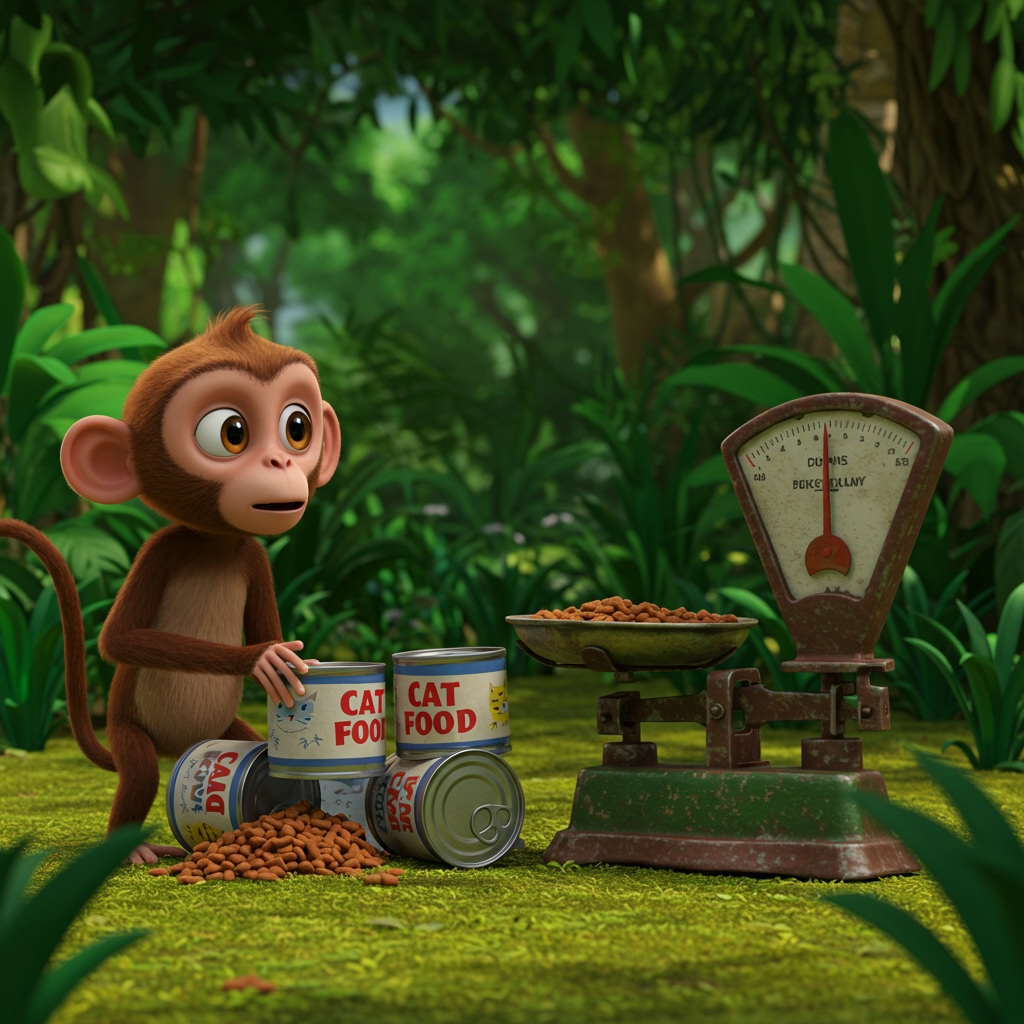

<ipython-input-44-5d7e98cbe1d6>:17: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await session.send(input=api_text, end_of_turn=True)


Processing scene 1:
Image Prompt: Monkey puts one cat food can on the weighting machine. The needle moves. Jungle background. Art style: kid's animation.
Audio Text: He wonders how heavy his treasure is, so he puts one can on the scale!
Character Description: Monkey: Pixar style, small brown monkey with big curious eyes, wearing a red vest. Cat Food: Shiny, metallic can on the scale. Weighting Machine: Old-fashioned scale, needle pointing to a weight.
--------------------------------


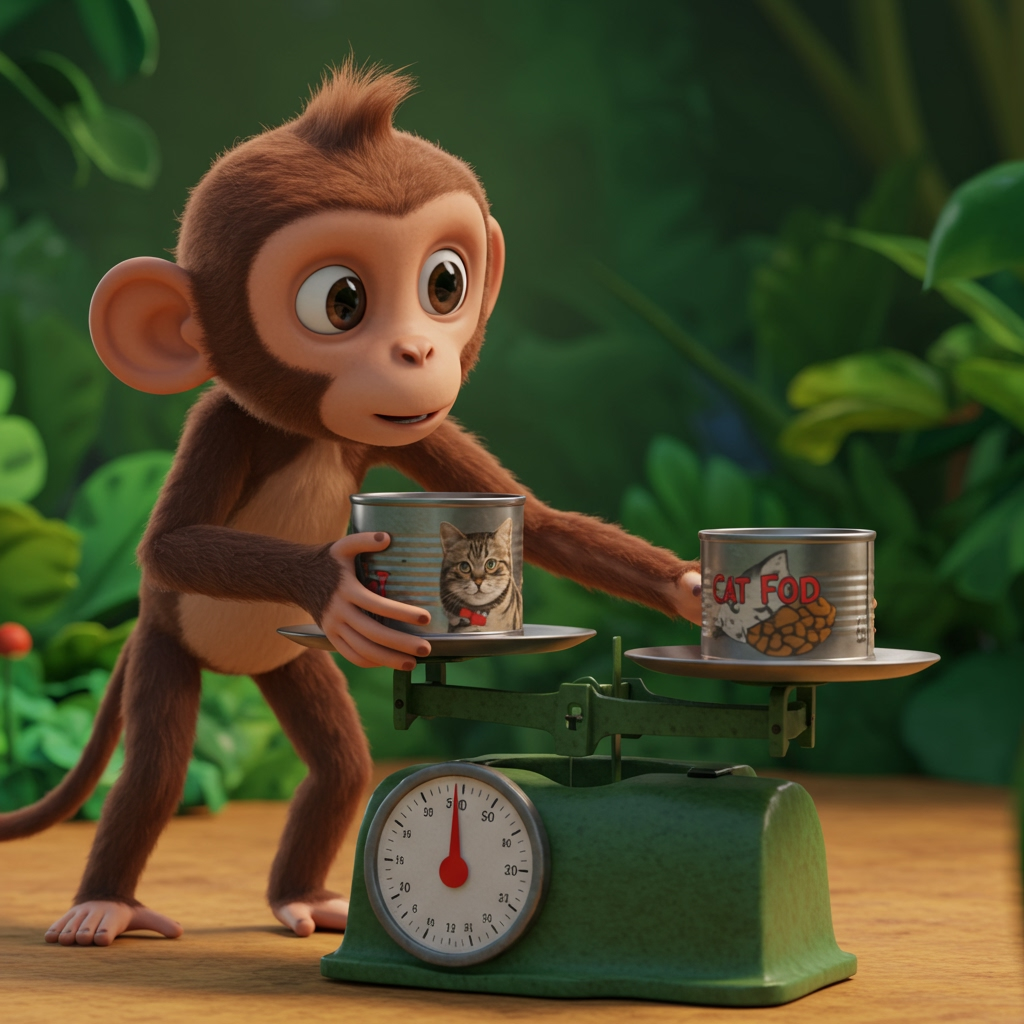

Processing scene 2:
Image Prompt: Monkey puts the second cat food can on the weighting machine. The needle moves higher. Jungle background. Art style: kid's animation.
Audio Text: Curious, he adds the second can to see the difference!
Character Description: Monkey: Pixar style, small brown monkey with big curious eyes, wearing a red vest. Cat Food: Two shiny, metallic cans on the scale. Weighting Machine: Old-fashioned scale, needle pointing to a higher weight.
--------------------------------


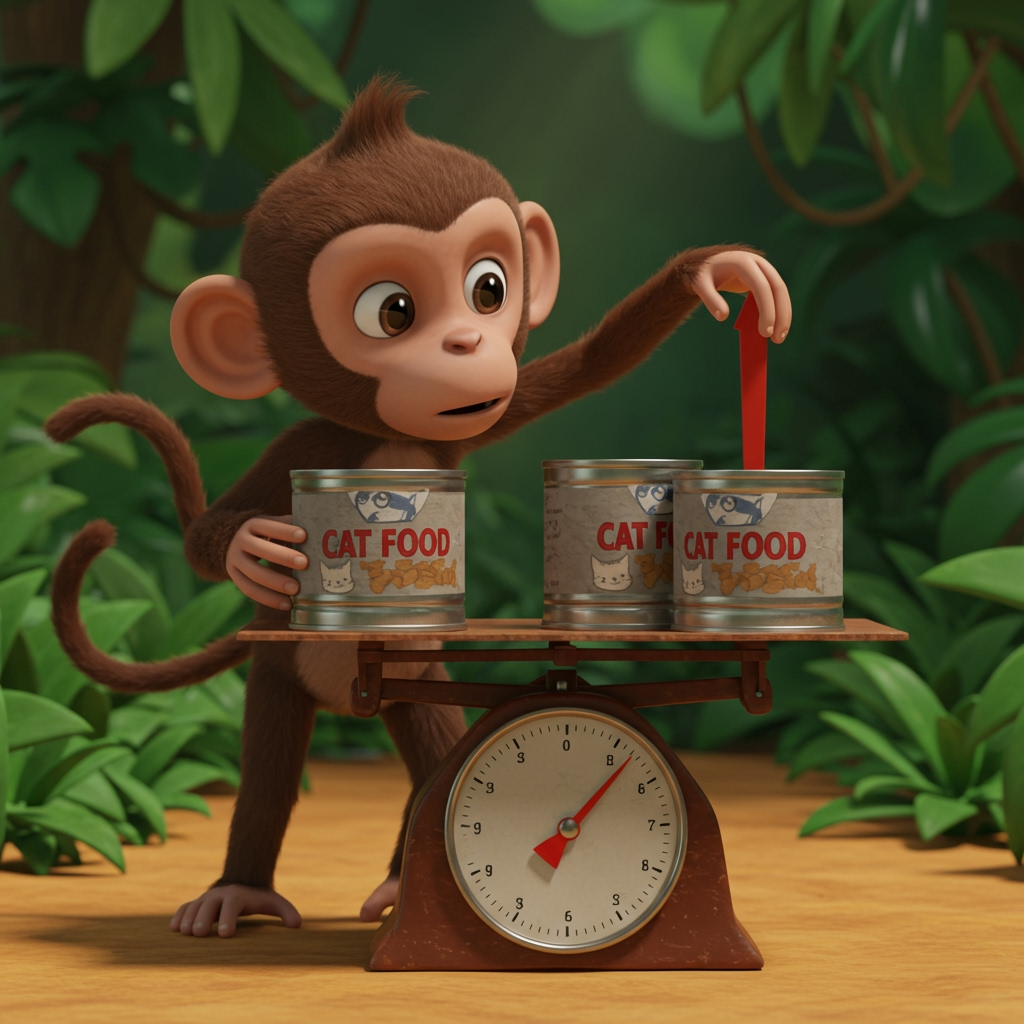

In [47]:
# --- Cell 3: Main processing loop ---
for i, segment in enumerate(story_segments):
    # Retrieve details for the current scene.
    image_prompt = segment['image_prompt']
    audio_text =  audio_negative_prompt + segment['audio_text']
    audio_text_prompt = segment['audio_text']
    char_desc = segment['character_description']
    print(f"Processing scene {i}:")
    print("Image Prompt:", image_prompt)
    print("Audio Text:", audio_text_prompt)
    print("Character Description:", char_desc)
    print("--------------------------------")

    # -------------------------
    # Image Generation using Google Imagen
    # -------------------------
    combined_prompt = "detailed children book animation style " + image_prompt + " " + char_desc

    result = client.models.generate_images(
        model=IMAGE_MODEL_ID,
        prompt=combined_prompt,
        config={
            "number_of_images": 1,
            "output_mime_type": "image/jpeg",
            "person_generation": "DONT_ALLOW",
            "aspect_ratio": "1:1"
        }
    )

    try:
        if not result.generated_images:
            raise ValueError("No images were generated. The prompt might have been flagged as harmful. Please modify your prompt and try again.")
        for generated_image in result.generated_images:
            image = Image.open(BytesIO(generated_image.image.image_bytes))
    except Exception as e:
        print("Image generation failed ", e)

    image_path = f"image_{i}.png"
    image.save(image_path)
    temp_image_files.append(image_path)
    display(image)

    # -------------------------
    # Audio Generation using Google Live API
    # -------------------------
    audio_path = f"audio_{i}.wav"
    audio_path = generate_audio_live(audio_text, audio_path)
    temp_audio_files.append(audio_path)


    # -------------------------
    # Create Video Clip (Image + Audio)
    # -------------------------
    audio_clip = AudioFileClip(audio_path)

    # Convert PIL Image to numpy array
    np_image = np.array(image)

    # Create ImageClip (size is inferred from np_image)
    image_clip = ImageClip(np_image).set_duration(audio_clip.duration)

    # Store composite clip with audio in memory
    composite_clip = CompositeVideoClip([image_clip]).set_audio(audio_clip)
    video_clips.append(composite_clip)

In [48]:
final_video = concatenate_videoclips(video_clips)
output_filename = f"{int(time.time())}_output_video.mp4"
print("Writing final video to", output_filename)
final_video.write_videofile(output_filename, fps=24)

# Display the video in the notebook
def show_video(video_path):
    """Display video in notebook"""
    video_file = open(video_path, "rb")
    video_bytes = video_file.read()
    video_b64 = b64encode(video_bytes).decode()
    video_tag = f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_b64}" type="video/mp4"></video>'
    return HTML(video_tag)

# Show the video
display(show_video(output_filename))

# Cleanup: Close video clips and remove temporary files
final_video.close()
for clip in video_clips:
    clip.close()
for file in temp_audio_files:
    os.remove(file)
for file in temp_image_files:
    os.remove(file)


# A video player will appear below

Writing final video to 1747232885_output_video.mp4
Moviepy - Building video 1747232885_output_video.mp4.
MoviePy - Writing audio in 1747232885_output_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video 1747232885_output_video.mp4



Moviepy - Done !
Moviepy - video ready 1747232885_output_video.mp4
